##### Notatki
Tutorial tutaj: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

Dane Flickr 8k:
https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

Polskie podpisy: http://zil.ipipan.waw.pl/Scwad/AIDe?action=AttachFile&do=get&target=AIDe_ANNOTATED_DESCRIPTIONS.zip

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf
from unidecode import unidecode

In [2]:
i = input("Czy używamy polskich znaków?(Y/N)")

polish_letters = i.lower() == 'y'

Czy używamy polskich znaków?(Y/N)y


In [3]:
import csv

captions_filename = f'../AIDe_ANNOTATED_DESCRIPTIONS/captions.csv'
tokens_filename = f'../AIDe_ANNOTATED_DESCRIPTIONS/token{"" if polish_letters else "-NO-PL"}.txt'
train_filename = f'../AIDe_ANNOTATED_DESCRIPTIONS/trainImages.txt'
test_filename = f'../AIDe_ANNOTATED_DESCRIPTIONS/testImages.txt'
descriptions_filename = f'descriptions-{"PL" if polish_letters else "NO-PL"}.txt'

# Polski zbiór podpisów uwzględnia jedynia 1k obrazów z Flickr
train_size = 750

with open(captions_filename, newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    img_names = []
    next(reader)
    with open(tokens_filename, 'w') as ft:
        for row in reader:
            img_name = row[1]
            caption1 = row[2] if polish_letters else unidecode(row[2])
            caption2 = row[3] if polish_letters else unidecode(row[3])
            print(f'{img_name}#0\t{caption1}', file=ft)
            print(f'{img_name}#1\t{caption2}', file=ft)
            img_names.append(img_name)

    with open(train_filename, 'w') as ft:
        for name in img_names[:train_size]:
            print(name, file=ft) 
    with open(test_filename, 'w') as ft:
        for name in img_names[train_size:]:
            print(name, file=ft) 

In [4]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load descriptions
doc = load_doc(tokens_filename)
print(doc[:300])

1355703632_5683a4b6fb.jpg#0	Młoda osoba w sportowym stroju i rękawicy robi duży krok, trzymając w jednej dłoni piłkę.
1355703632_5683a4b6fb.jpg#1	Dziewczyna z rękawicą na ręce biegnie po boisku z żółtą piłką w drugiej ręce.
2101128963_fdf8b2a0d7.jpg#0	Zawodnik na boisku ze skórzaną rękawicą robi wyk


In [5]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 1000 


In [6]:
list(descriptions.keys())[:5]

['1355703632_5683a4b6fb',
 '2101128963_fdf8b2a0d7',
 '241345522_c3c266a02a',
 '241347460_81d5d62bf6',
 '2521938802_853224f378']

In [7]:
descriptions['1355703632_5683a4b6fb']

['Młoda osoba w sportowym stroju i rękawicy robi duży krok, trzymając w jednej dłoni piłkę.',
 'Dziewczyna z rękawicą na ręce biegnie po boisku z żółtą piłką w drugiej ręce.']

In [8]:
descriptions['2521938802_853224f378']

['Mężczyzna w białym sportowym stroju i czarnym kasku stoi na trawie na zgiętych nogach, trzymając za plecami grubą pałkę.',
 'Mężczyzna z ochraniaczami na nogach stoi na trawie w rozkroku.']

In [9]:
import spacy
nlp = spacy.load('pl_spacy_model')

def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      doc = nlp(desc)
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
# Lematyzacja
#### spacy model from here: http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=view&target=pl_spacy_model-0.1.0.tar.gz
#### spacy dokumentacja - https://spacy.io/usage
      desc = [word.lemma_ for word in doc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'pl_model' (0.1.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [10]:
descriptions['1355703632_5683a4b6fb']

['młody osoba w sportowy strój i rękawica robić duży krok trzymać w jeden dłoń piłka',
 'dziewczyna z rękawica na ręka biec po boisko z żółty piłka w drugi ręka']

In [11]:
descriptions['2521938802_853224f378']

['mężczyzna w biały sportowy strój i czarny kask stać na trawa na zgiąć noga trzymać za plecy gruby pałka',
 'mężczyzna z ochraniacz na noga stać na trawa w rozkrok']

In [12]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 1811


In [13]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w', encoding='utf-8')
	file.write(data)
	file.close()

save_descriptions(descriptions, descriptions_filename)

In [14]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
train = load_set(train_filename)
print('Dataset: %d' % len(train))

Dataset: 750


In [15]:
# Below path contains all the images
images = '../Flickr8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [16]:
# Read the train image names in a set
train_images = set(open(train_filename, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [17]:
# Below file conatains the names of images to be used in test data
test_images_file = test_filename
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [18]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(descriptions_filename, train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=750


In [19]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [20]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [21]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [22]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

###### Notatki
Poniższy kod zajmuje bardzo dużo czasu.

In [23]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
    print('.', end='')
print("Time taken in seconds =", time()-start)

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Time taken in seconds = 161.0953710079193


In [24]:
import os
import pickle

writepath = f'../Pickle/encoded_train_images_{"pl" if polish_letters else "no_pl"}.pkl'

mode = 'a' if os.path.exists(writepath) else 'wb'

# Save the bottleneck train features to disk
with open(f'../Pickle/encoded_train_images_{"pl" if polish_letters else "no_pl"}.pkl', "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [25]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
    print('.', end='')
print("Time taken in seconds =", time()-start)

..........................................................................................................................................................................................................................................................Time taken in seconds = 50.38689303398132


In [26]:
# Save the bottleneck test features to disk
with open(f'../Pickle/encoded_test_images_{"pl" if polish_letters else "no_pl"}.pkl', "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [27]:
train_features = load(open(f'../Pickle/encoded_train_images_{"pl" if polish_letters else "no_pl"}.pkl', "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=750


In [28]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

1500

In [29]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 1560 -> 241


In [30]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [31]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

242

In [32]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 36


In [33]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
#                 yield [[array(X1), array(X2)], array(y)]
                yield ([array(X1), array(X2)], array(y)) 
                X1, X2, y = list(), list(), list()
                n=0

Embedings pobrane stąd: https://github.com/sdadas/polish-nlp-resources/releases/download/v1.0/glove.zip

In [34]:
# Load Glove vectors
glove_dir = '../glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove_100_3_polish.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0] if polish_letters else unidecode(values[0])
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1926321 word vectors.


In [35]:
embedding_dim = 100

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_matrix.shape

(242, 100)

In [37]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [38]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 100)      24200       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [39]:
model.layers[2]

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [42]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

Kolejny dość czasochłonny krok

In [43]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    print(generator)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    writepath = f'../model_weights/model_{str(i)}_{"pl" if polish_letters else "no_pl"}.h5'

    mode = 'a' if os.path.exists(writepath) else 'wb'
#     file = open(writepath, mode)
    model.save(writepath)

<generator object data_generator at 0x7f9885fb3a98>
Instructions for updating:
Please use Model.fit, which supports generators.
250/250 [==============================] - 36s 146ms/step - loss: 4.3686
<generator object data_generator at 0x7f98b907ae58>
250/250 [==============================] - 36s 143ms/step - loss: 3.8533
<generator object data_generator at 0x7f9885f969a8>
250/250 [==============================] - 36s 143ms/step - loss: 3.6250
<generator object data_generator at 0x7f98baf678b8>
250/250 [==============================] - 35s 142ms/step - loss: 3.4788
<generator object data_generator at 0x7f9885f96c00>
250/250 [==============================] - 37s 147ms/step - loss: 3.2848
<generator object data_generator at 0x7f98b9d10b10>
250/250 [==============================] - 39s 156ms/step - loss: 3.1408
<generator object data_generator at 0x7f98bb8014f8>
250/250 [==============================] - 37s 148ms/step - loss: 3.0164
<generator object data_generator at 0x7f98856fc48

In [44]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(f'../model_weights/model_{str(i)}_{"pl" if polish_letters else "no_pl"}.h5')

250/250 [==============================] - 41s 165ms/step - loss: 1.8560


In [45]:
# model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [46]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

125/125 [==============================] - 29s 230ms/step - loss: 1.4575


In [47]:
model.save_weights(f'../model_weights/model_30_{"pl" if polish_letters else "no_pl"}.h5')

In [48]:
model.load_weights(f'../model_weights/model_30_{"pl" if polish_letters else "no_pl"}.h5')

In [49]:
images = '../Flickr8k_Dataset/'

In [50]:
with open(f'../Pickle/encoded_test_images_{"pl" if polish_letters else "no_pl"}.pkl', "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [51]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

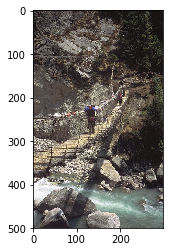

Greedy: pies z obroża na szyja skakać z drewniany do woda


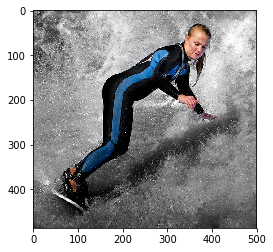

Greedy: dziewczynka w kostium kąpielowy i kask jechać na narta po


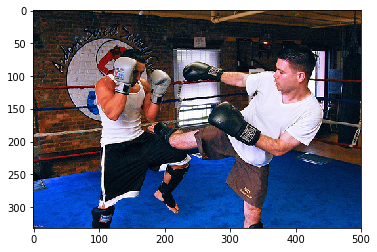

Greedy: pies biec po trawa trzymać w pysk piłka


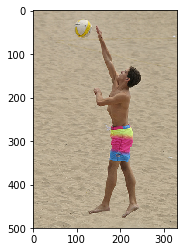

Greedy: dwa kobieta w sportowy strój się do piłka a dwa dziewczynka biec w on strona


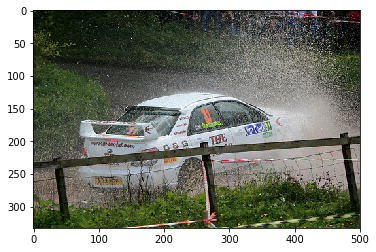

Greedy: dwa pies biec po trawa trzymać w pysk piłka


In [52]:
for i in range(0,5):
    pic = list(encoding_test.keys())[i]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))

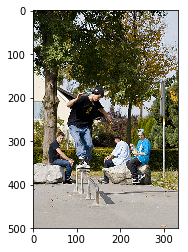

Greedy: mężczyzna w czerwony kurtka jechać na rolka po plac pod ściana budynek
['chłopak w luźny ubranie jechać na rolka po niski barierka a trzy inny chłopak przyglądać on się siedzieć na kamień', 'trzy osoba przyglądać się jak chłopak na rolka zjeżdżać po barierka']


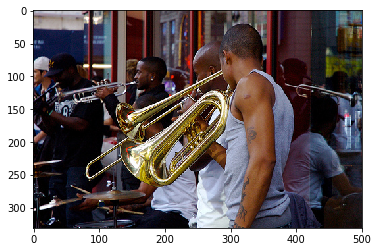

Greedy: duży pies podskakiwać przez na
['ciemnoskórzy mężczyzna grać na instrument tuż przed budynek', 'kilka mężczyzna grać na instrument dęty i perkusja pod okno budynek']


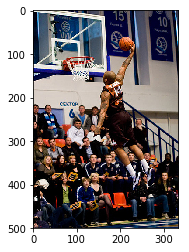

Greedy: ciemnoskóry wykonywać w sportowy strój biec w kierunek piłka do piłka a dwa inny chłopak iść w on strona
['kibic na trybuna obserwować jak mężczyzna z tatuaż na ręka wrzucać piłka do kosz', 'koszykarz obserwować przez widownia skakać do kosz z piłka w ręka']


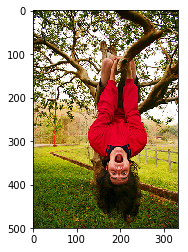

Greedy: dziewczynka w kask jechać na hulajnoga po barierka
['człowiek z długi włos wisieć nad trawa na gałęzie drzewo głowa w dół', 'chłopak z długi włos wisieć głowa w dół na gałęzie drzewo']


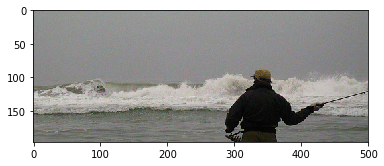

Greedy: kobieta w kostium kąpielowy czapka z daszek i koszulka koszulka stać w woda z buta w ręka
['mężczyzna w czapka i kurtka stać nad wzburzyć woda trzymać cienki podłużny przedmiot', 'mężczyzna z wędka stać zwrócić w kierunek falujący morze']


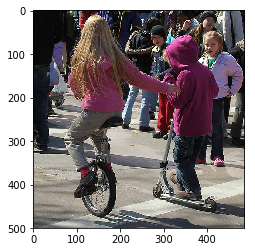

Greedy: dziewczynka jechać na a drugi dziecko jechać na hulajnoga
['dziewczynka w długi włos przejeżdżać monocykl obok dziecko na hulajnoga', 'dziewczynka jechać na monocykl a drugi dziecko jechać na hulajnoga']


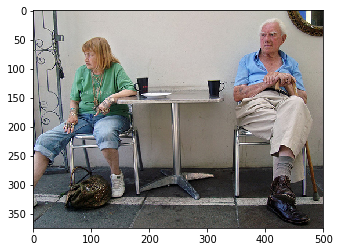

Greedy: kobieta i mężczyzna się siedzieć na ławka
['kobieta i mężczyzna z laska siedzieć przy wielki metalowy stolik', 'kobieta i stary mężczyzna z laska siedzieć przy stolik na który stać dwa czarny kubek']


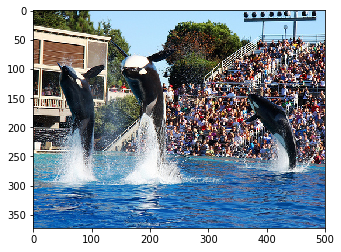

Greedy: lud w kapelusz siedzieć na skała na różowy woda
['trzy orka skakać nad woda obserwować przez publiczność', 'lud na trybuna obserwować trzy skakać nad woda orka']


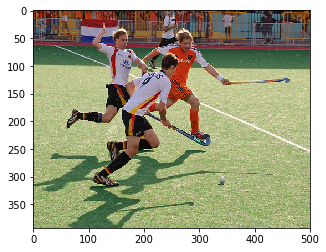

Greedy: trzy podskakiwać na boisko podskakiwać w piłka piłka a piłka lecieć piłka
['trzy mężczyzna w sportowy strój biec w strona piłka podczas gra w hokej na trawa', 'trzy zawodnik z kije do hokej biec po trawa za piłka']


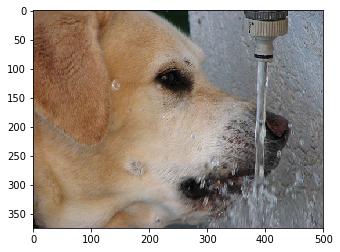

Greedy: pies biec po trawa trzymać w pysk piłka
['pies podstawiać pysk pod spływać woda', 'jasno ubarwić pies pić woda z kran']


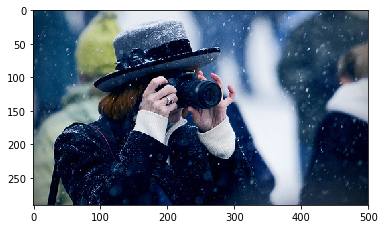

Greedy: dwa osoba jechać na koń po plaża
['kobieta w kapelusz robić zdjęcie podczas opad śnieg', 'kobieta w kapelusz patrzyć przez obiektyw aparat w czas kiedy padać śnieg']


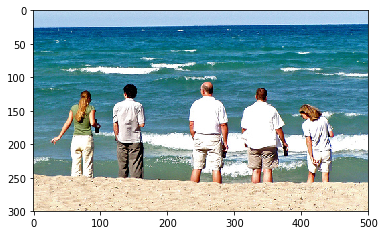

Greedy: kobieta w kostium kąpielowy stać na plaża trzymać na pies
['pięć człowiek stać nad brzeg morze w słoneczny dzienie', 'pięć osoba w jasny strój zwrócić w kierunek woda stać obok siebie na plaża']


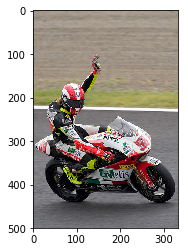

Greedy: człowiek w kask i kombinezon jechać na motocykl z jeden noga
['człowiek w kask i kombinezon jechać na motocykl z podnieść ręka', 'osoba jechać po asfalt sportowy motocykl z unieść do góra ręka']


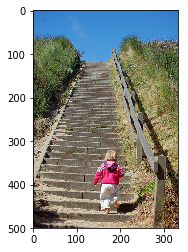

Greedy: pies biec po trawa trzymać w pysk piłka
['dziewczynka z bosymi stopa wchodzić do góra po długi schód', 'dziecko wchodzić po wysoki schód obsypać piasek']


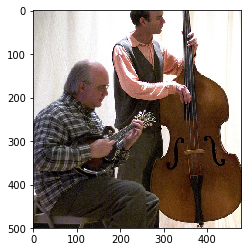

Greedy: duży pies podskakiwać naprzeciwko siebie
['mężczyzna w okulary siedzieć grać na mandolinie a obok on stać mężczyzna grać na kontrabas', 'jeden mężczyzna siedzieć i grać na mały gitara a drugi mężczyzna stać i grać na kontrabas']


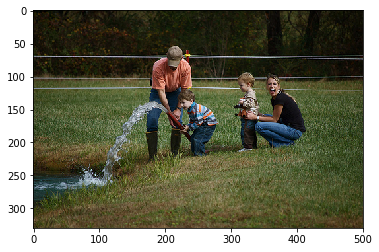

Greedy: dziewczynka w kask jechać na hulajnoga po barierka
['mężczyzna w kalosz wraz z mały chłopiec lać woda do zbiornik wodny w pobliże znajdywać się obok kobieta z dziecko', 'mężczyzna i chłopiec trzymać rura z który lać się woda a kobieta kuc i trzymać drugi chłopiec']


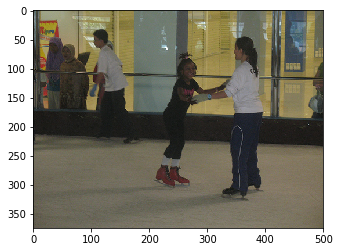

Greedy: dziewczynka w różowy strój i czapka siedzieć na trawa z unieść ręka w ręka
['ciemnoskóry dziewczynka jechać po lód na czerwony łyżwa podtrzymywać się jednocześnie drugi osoba', 'kobieta i dziewczynka stać na łyżwa na lodowisko trzymać się za ręka']


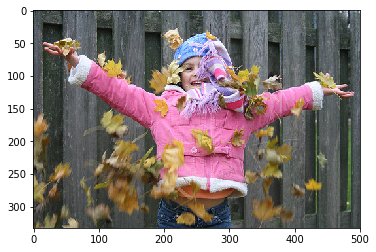

Greedy: dziewczynka w czerwony bluza stać na chodnik obok
['dziewczynka w różowy kurtka bawić się pożółkły liść', 'uśmiechnięty dziewczynka w różowy kurtka stać wśród rozrzucić zeschniętych liść']


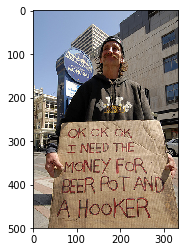

Greedy: kobieta i mężczyzna się siedzieć na ławka
['mężczyzna z kartonowy tablica z napis stać na ulica', 'mężczyzna w czapka trzymać w ręka fragment karton z czerwony napis']


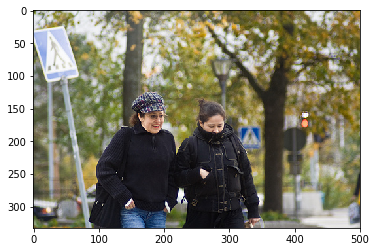

Greedy: kobieta w czerwony bluzka i stać zwrócić w kierunek woda
['dwa kobieta jeden w czapka i czarny sweter a drugi w czarny kurtka iść obok siebie w pobliże drzewo', 'dwa kobieta iść obok siebie w pobliże przejście dla pieszy']


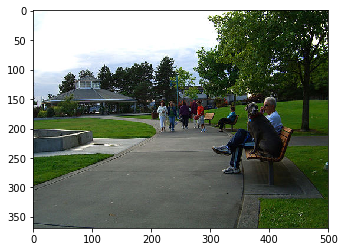

Greedy: kobieta i mężczyzna się siedzieć na ławka
['duży pies siedzieć na ławka obok mężczyzna w okulary przeciwsłoneczny', 'mężczyzna i duży pies siedzieć na ławka obok chodnik po który spacerować daleko lud']


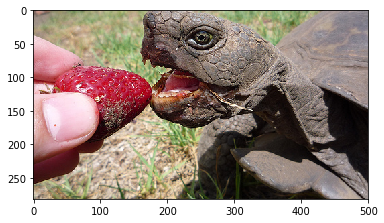

Greedy: człowiek pod woda
['żółw lądowy otwierać paszcza pod który człowiek podstawiać truskawka', 'żółw otwierać pysk wówczas gdy człowiek podawać on truskawka']


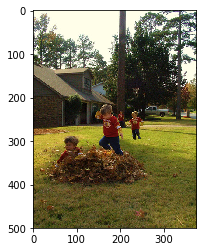

Greedy: chłopiec w kask jechać na rolka po plac
['chłopiec biec w kierunek dwa inny chłopiec bawić się przy stos pożółkłych liść', 'dwa dziecko w czerwony koszulka bawić się w sterta liść a kolejny dwa dziecko biec w on strona']


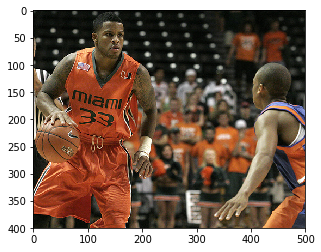

Greedy: ciemnoskóry w strój piłka piłka do
['ciemnoskóry koszykarz z tatuaż na ciało odbijać piłka obok niski od siebie koszykarz', 'koszykarz w pomarańczowy strój kozłować piłka a obok stać drugi gracz trzymać ręka wyciągnąć w bok']


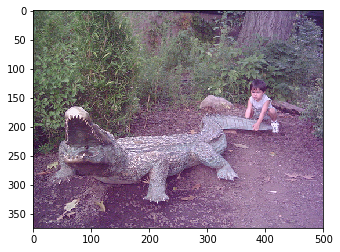

Greedy: pies biec po trawa trzymać w pysk piłka
['mały chłopiec kuc trzymać za ogon duży sztuczny krokodyl', 'chłopiec trzymać za ogon krokodyl z otwarty paszcza']


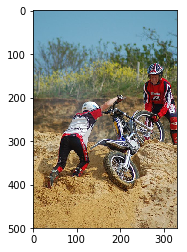

Greedy: dwa osoba w kask i kombinezon jechać siebie na rower
['dwa osoba w kask wyciągać motocykl z piasek', 'osoba w kask wspinać się po piach pchać motor wspomagać przez drugi człowiek']


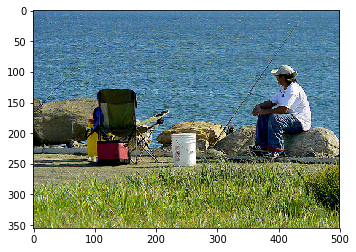

Greedy: kobieta w czerwony czapka i trzy mały chłopiec iść jeden za drugi po plaża
['mężczyzna w kapelusz siedzieć nad woda na duży kamień obok podpartej wędka', 'człowiek w kapelusz siedzieć na kamień nad woda obok wiadro i rozkładanego krzesło']


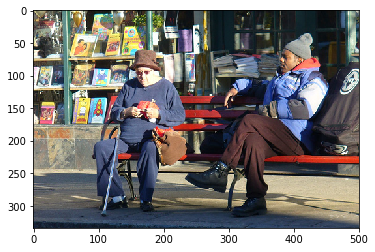

Greedy: kobieta i mężczyzna się siedzieć na ławka
['kobieta z laska i mężczyzna w kurtka i czapka siedzieć na czerwony ławka obok księgarnia', 'stary kobieta z laska siedzieć przed księgarnia na ławka obok ciemnoskóry mężczyzna']


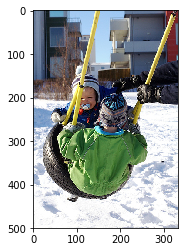

Greedy: mężczyzna w kamizelka i duży koszulka siedzieć na kamienisty plaża patrzyć na duży
['dwa mały dziecko bujać się razem na huśtawka z opona', 'dwa dziecko w zimowy strój siedzieć w huśtawka zrobić z opona bujać przez osoba w czarny rękawiczka']


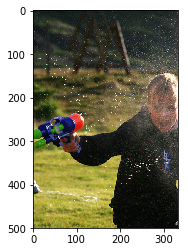

Greedy: dziewczynka w różowy strój bawić się w basen podtrzymywać przez inny pies
['chłopiec w czarny bluza trzymać pistolet na woda i sam też być polewać woda', 'mokry chłopiec trzymać w ręka kolorowy pistolet na woda']


In [53]:
for i in range(0,30):
    pic = list(encoding_train.keys())[i]
    image = encoding_train[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))
    print(descriptions[pic[:-4]])

In [54]:
import nltk
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/annakonieczna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


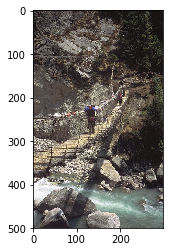

Test 0 : pies z obroża na szyja skakać z drewniany do woda
Meteor score:  0.045871559633027525


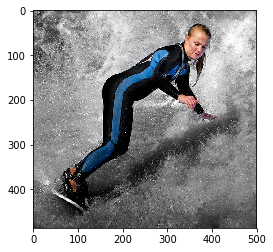

Test 1 : dziewczynka w kostium kąpielowy i kask jechać na narta po
Meteor score:  0.15


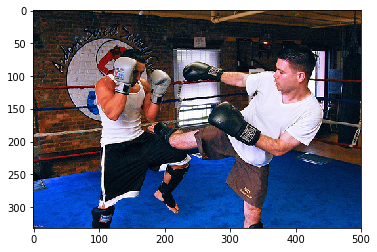

Test 2 : pies biec po trawa trzymać w pysk piłka
Meteor score:  0.0625


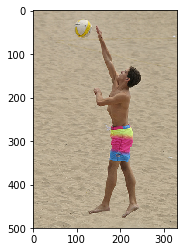

Test 3 : dwa kobieta w sportowy strój się do piłka a dwa dziewczynka biec w on strona
Meteor score:  0.1149425287356322


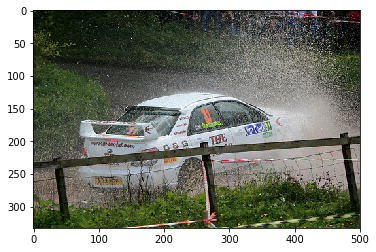

Test 4 : dwa pies biec po trawa trzymać w pysk piłka
Meteor score:  0.046296296296296294


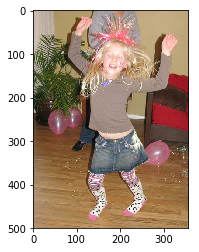

Test 5 : dwa pies biec po trawa trzymać w pysk piłka
Meteor score:  0.0


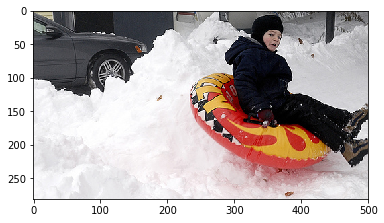

Test 6 : pies biec po śnieg
Meteor score:  0.0


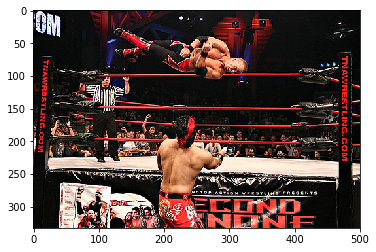

Test 7 : duży pies podskakiwać przez z
Meteor score:  0.05813953488372093


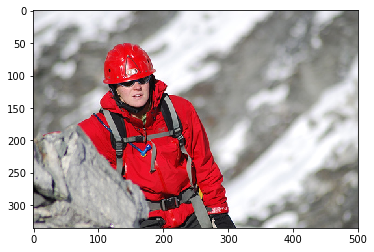

Test 8 : cztery osoba w kask i kombinezon jechać na rower z góra
Meteor score:  0.27777777777777773


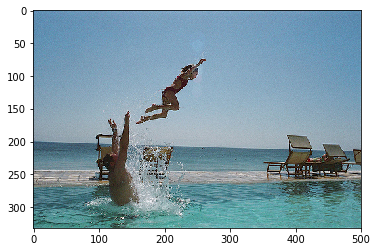

Test 9 : dziewczynka w kostium kąpielowy stać w woda trzymać jeden ręka
Meteor score:  0.2929133858267717


In [58]:
pics = list(encoding_test.keys())
for i in range(0,10):
    pic = pics[i]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    caption = greedySearch(image)
    print("Test",i,":",caption)
    print("Meteor score: ", meteor_score(descriptions[pic.split('.')[0]],caption))

In [70]:
pics_pl = list(encoding_train.keys())
pics__no_pl = list(encoding_train.keys())

bleu_scores_pl = []
meteor_scores_pl=[]
bleu_scores_no_pl = []
meteor_scores_no_pl=[]

for i in range(0,len(pics_pl)):
    pic_pl = pics_pl[i]
    pic_no_pl = pics_pl[i]
    image_pl = encoding_train[pic_pl].reshape((1,2048))
    image_no_pl = encoding_train[pic_no_pl].reshape((1,2048))

    actual_desc_0_pl = descriptions[pic_pl[:-4]][0]
    actual_desc_1_pl = descriptions[pic_pl[:-4]][1]
    generated_pl = greedySearch(image_pl)
    bleu_scores_pl.append(
        sentence_bleu(
            [actual_desc_0_pl.split(), actual_desc_1_pl.split()],
            generated_pl.split())
    )
    meteor_scores_pl.append(meteor_score(descriptions[pic.split('.')[0]],generated_pl))
    
    actual_desc_0_no_pl = descriptions[pic_no_pl[:-4]][0]
    actual_desc_1_no_pl = descriptions[pic_no_pl[:-4]][1]
    generated_no_pl = greedySearch(image_no_pl)
    bleu_scores_no_pl.append(
        sentence_bleu(
            [actual_desc_0_no_pl.split(), actual_desc_1_no_pl.split()],
            generated_no_pl.split())
    )
    meteor_scores_no_pl.append(meteor_score(descriptions[pic_no_pl.split('.')[0]],generated_no_pl))
    


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram o

NameError: name 'mean' is not defined

In [71]:
from statistics import mean
print("BLEU TRAIN PL:",mean(bleu_scores_pl))
print("BLEU TRAIN NO PL:",mean(bleu_scores_no_pl))
print("METEOR TRAIN PL:",mean(meteor_scores_pl))
print("METEOR TRAIN NO PL:",mean(meteor_scores_no_pl))

BLEU TRAIN PL: 0.04995636511638307
BLEU TRAIN NO PL: 0.04995636511638307
METEOR TRAIN PL: 0.09074458653711735
METEOR TRAIN NO PL: 0.21741580796934312
